In [1]:
!dir
from commonfunctions import *
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import skimage
from skimage.color import rgb2gray
from skimage.morphology import disk, square, rectangle as rect

from skimage.morphology import(binary_erosion, 
                               binary_dilation,
                               binary_closing,
                               skeletonize,
                               thin,
                               opening
                              )
from skimage.measure import find_contours

from skimage.draw import rectangle
from skimage.filters import threshold_otsu


 Volume in drive C has no label.
 Volume Serial Number is B4DA-B24E

 Directory of C:\Users\mohammed\projects\music-notes-reader

12/26/2020  02:57 PM    <DIR>          .
12/26/2020  02:57 PM    <DIR>          ..
12/05/2020  03:47 PM             1,928 .gitignore
12/05/2020  04:50 PM    <DIR>          .ipynb_checkpoints
12/13/2020  07:54 PM             3,115 commonfunctions.py
12/21/2020  12:57 PM             3,778 commonfunctions.pyc
12/22/2020  02:44 PM             8,437 environment.yml
12/26/2020  03:35 PM    <DIR>          images
12/25/2020  09:06 PM    <DIR>          no_line_test
12/26/2020  02:57 PM           244,280 part1.ipynb
12/24/2020  03:48 PM             2,196 README.md
12/21/2020  03:43 PM    <DIR>          single-dataset
12/05/2020  03:47 PM           514,072 [IP] Project F2020_ Sheet Music Reader.pdf
12/13/2020  08:00 PM    <DIR>          __pycache__
               7 File(s)        777,806 bytes
               7 Dir(s)  290,778,632,192 bytes free


In [2]:
import cv2
if ' ':
    print('hi')

hi


In [3]:
# omar do those
def which_number(num_image):
    """
    returns: zero is image wasn't a number
    or returns the number that it represents either
    1, 2, 3, 4, ...., 9
    
    arguments:
    num_image: this is an image of small size
    """
    pass

def which_symbol_division(sym_image):
    """
    returns which duration eg, if a/4 return 4, if a/8 return 8, if a/16, a/32 
    if not any one return 0
    
    arguments:
    sym_image: this is an image of small size
    """
    pass



In [4]:
# atia do this


def number_of_beams(sym_image):
    """
    returns the number of beams that are found in beaming symbols    
    arguments:
    sym_image: this is an image of small size
    """
    pass

def filled_holes_centers(sym_image):
    """
    returns: the centers of the filed holes found in the sym_image
    eg: [(x1,y1), (x2,y2)]
    arguments:
    sym_image: this is an image of small size
    """
    pass

def which_accidentals(sym_image):
    """
    returns: accidental is found in that image
    returns '#' if # or '&' if b or ' '(space) if neutral '##' if X '&&' if bb
    or return ''(empty) or None if not any of these
    arguments:
    sym_image: this is an image of small size
    """
    pass

In [75]:
# cv2  common functions
def remove_horizontal_lines_old(image):
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    gray=255 - thresh
    # Remove horizontal
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25,1))
    detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
    cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    cv2.drawContours(gray, cnts, -1, 255, 2)

    # Repair image
    repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,6))
    result =cv2.morphologyEx(255 - gray, cv2.MORPH_CLOSE, repair_kernel, iterations=1)
    result[result < 100]= 0 
    result [result >= 100] = 255
    return result

def remove_horizontal_lines(image, staff_height=3):
    return binary_erosion(image, selem=rect(staff_height,1))

In [80]:
# common functions

def get_bounding_boxes(img,box_aspect_ratio):
    """
    summary: this function returns the bounding boxes sorted according to x-min
    parameter:
    img: is a binary image for which to find the contours 
    aspect_ratio: is a tuple where (low_aspect_ratio,high_aspect_ratio)
    """
    contours = find_contours(img,.8)
    bounding_boxes=[]
    for contour in contours:
        Xmin= np.min(contour[:,1])
        Xmax=np.max(contour[:,1]) 
        Ymin=np.min(contour[:,0])
        Ymax = np.max(contour[:,0])
        if(Ymax-Ymin != 0):
            aspect_ratio = (Xmax-Xmin)/(Ymax-Ymin)
        else:
            aspect_ratio = 3000
            
        if aspect_ratio >= box_aspect_ratio[0] and aspect_ratio <= box_aspect_ratio[1]:
            bounding_boxes.append([int(round(Xmin)),int(round(Xmax)),int(round(Ymin)),int(round(Ymax))])
    def x_min(shape):
        return shape[0]
               
                
    bounding_boxes = sorted(bounding_boxes, key=x_min)
    return bounding_boxes


def get_bounded_image(img,bounding_boxes):
    conte = np.zeros(img.shape)
    for box in bounding_boxes:
        [Xmin, Xmax, Ymin, Ymax] = box
        rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=img.shape)
        rr = rr.astype(np.int)
        cc= cc.astype(np.int)
        conte[rr, cc] = 1 #set color white
    img2 = np.where(conte==1, img, 0)
    return img2
def draw_bounding_boxes(img,bounding_boxes):
    conte = np.zeros(img.shape)
    for box in bounding_boxes:
        [Xmin, Xmax, Ymin, Ymax] = box
        rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=img.shape)
        rr = rr.astype(np.int)
        cc= cc.astype(np.int)
        conte[rr, cc] = 1 #set color white
    img2 = np.where(conte==1, img, 0)
    show_images([conte,img2], ['bounding_boxes','original segmented'])


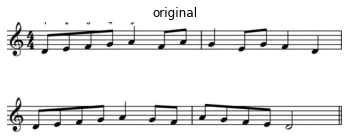

In [18]:
images_paths = ['images/music1.JPG','images/8th_Sheet1.jpeg']

original_image = io.imread(images_paths[1])
gray_image = rgb2gray(original_image)
binary_image = binarize(gray_image)
inverted_image = 255 - binary_image
show_images([original_image],['original'])

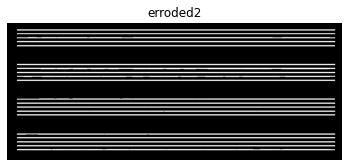

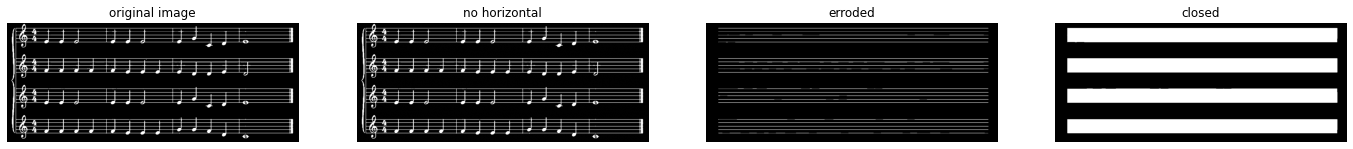

In [68]:
images_paths = ['images/music1.JPG','images/8th_Sheet1.jpeg']

original_image = io.imread(images_paths[0])
gray_image = rgb2gray(original_image)
binary_image = binarize(gray_image)
inverted_image = 255 - binary_image

# inverted_image[:,0] = 0
inverted_image[:, inverted_image.shape[1]-1]=0
# show_images([inverted_image,erroded_img,closed_img],['original image','erroded','closed'])
rows=1
cols=35
selem = rect(rows,cols)
erroded_img = binary_erosion(inverted_image,selem=selem)
rows=4
cols=35
selem = rect(rows,cols)
erroded_img2 = binary_dilation(erroded_img, selem=selem)
inverted_image2 = inverted_image - erroded_img2

show_images([erroded_img2], ['erroded2'])

rows = 20
cols = 1
selem = rect(rows,cols)
closed_img  = binary_closing(erroded_img, selem = selem)
show_images([inverted_image,inverted_image2,erroded_img,closed_img],['original image','no horizontal','erroded','closed'])

In [69]:
#  calculate the trace bounding boxes
trace_bounding_boxes = get_bounding_boxes(closed_img,(10,4000))
print(trace_bounding_boxes)
bigger_trace_bounding_boxes = []
trace_images_array = []
division_height=0
trace_height = 0
for box in trace_bounding_boxes:
    trace_height = box[3]-box[2]
    division_height = (trace_height)/4
    division_height = int(np.ceil(division_height)) 
#     division_height *=2
    [Xmin, Xmax, Ymin, Ymax] = [int(round(x)) for x in box]
    Ymin -= 2 * division_height
    Ymin = Ymin if Ymin >0 else 0
    Ymax += 2 * division_height
    bigger_trace_bounding_boxes.append([Xmin, Xmax, Ymin, Ymax])
    
    trace_images_array.append(gray_image[Ymin:Ymax,Xmin:Xmax])
print(bigger_trace_bounding_boxes)
print(inverted_image.shape)

aspect ratio 19.19277108433735
aspect ratio 19.1777108433735
aspect ratio 19.1777108433735
aspect ratio 19.47094801223241
[[57, 1331, 28, 94], [58, 1331, 170, 236], [58, 1331, 312, 378], [58, 1331, 456, 521]]
[[57, 1331, 0, 128], [58, 1331, 136, 270], [58, 1331, 278, 412], [58, 1331, 422, 555]]
(563, 1377)


[57, 1331, 0, 128]


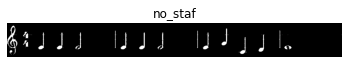

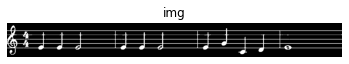

[58, 1331, 136, 270]


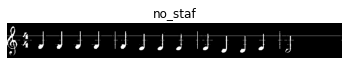

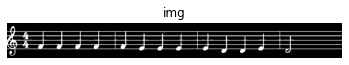

[58, 1331, 278, 412]


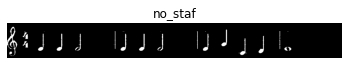

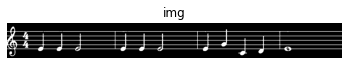

[58, 1331, 422, 555]


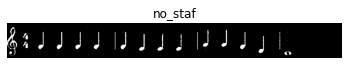

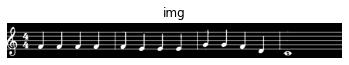

In [77]:
# for each trace segment the individual characters
staff_images = []
gray_staff_images=[]

for trace in bigger_trace_bounding_boxes:
    [Xmin, Xmax, Ymin, Ymax] = [x for x in trace]
    print(trace)
    no_staf = remove_horizontal_lines(inverted_image[Ymin:Ymax,Xmin:Xmax])
    show_images([no_staf], ['no_staf'])
    show_images([inverted_image[Ymin:Ymax,Xmin:Xmax]], ['img'])
    
    staff_images.append(inverted_image[Ymin:Ymax,Xmin:Xmax])    
    gray_staff_images.append(gray_image[Ymin:Ymax,Xmin:Xmax])


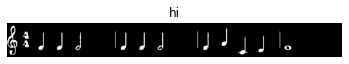

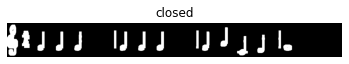

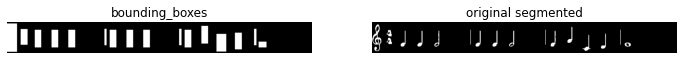

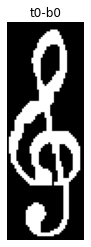

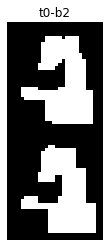

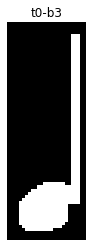

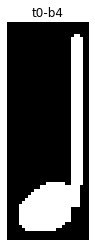

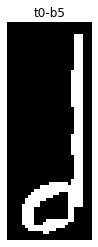

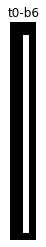

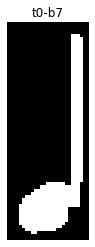

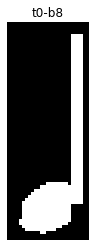

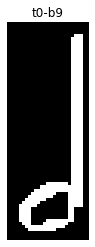

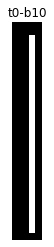

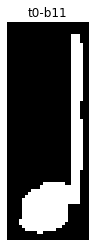

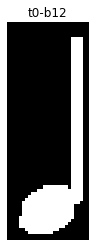

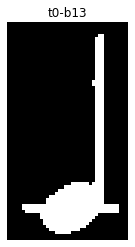

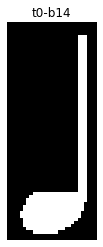

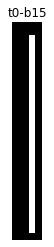

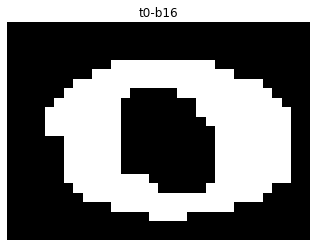

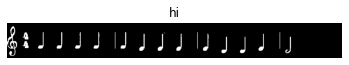

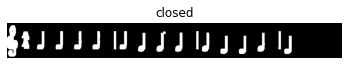

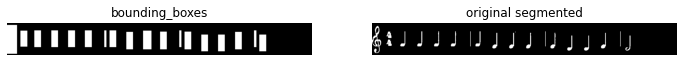

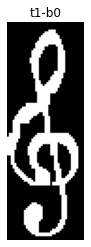

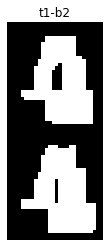

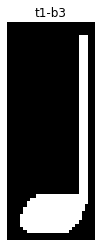

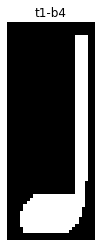

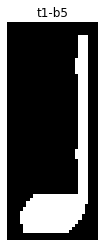

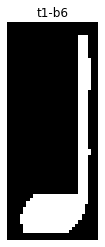

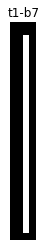

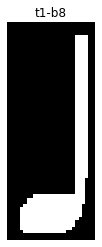

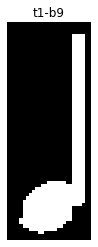

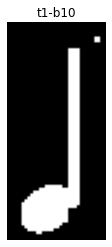

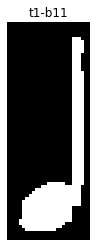

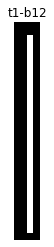

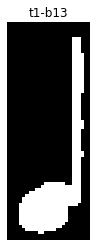

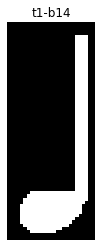

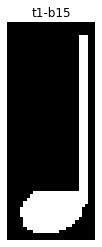

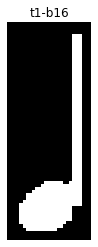

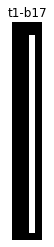

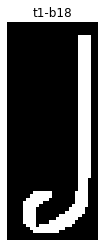

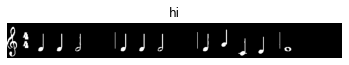

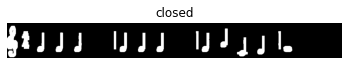

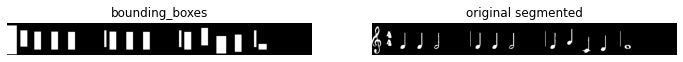

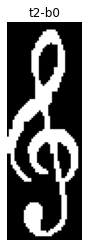

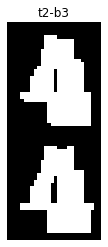

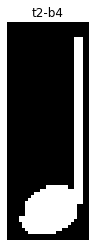

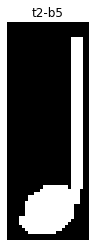

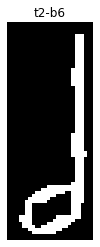

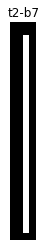

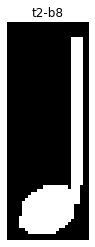

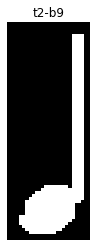

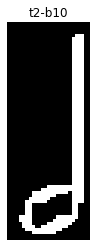

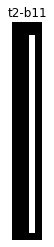

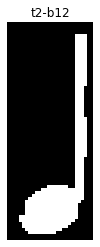

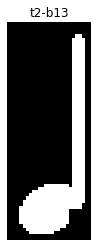

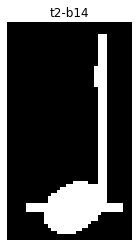

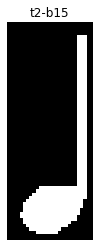

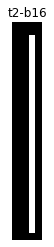

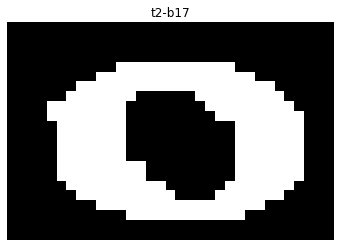

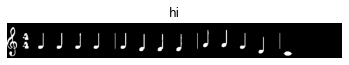

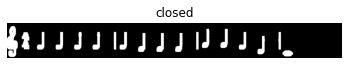

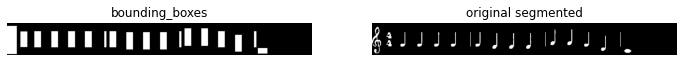

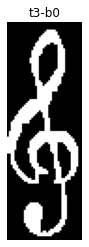

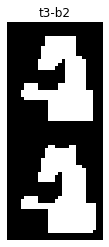

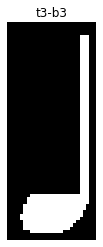

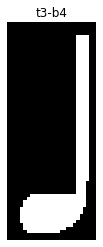

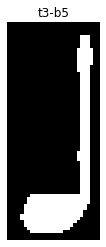

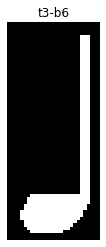

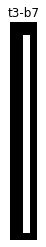

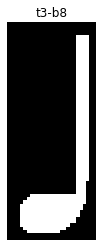

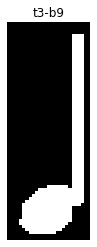

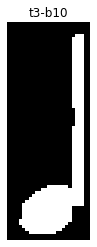

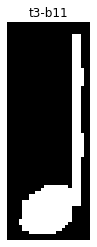

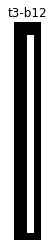

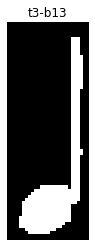

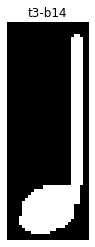

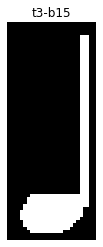

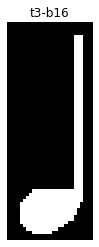

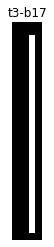

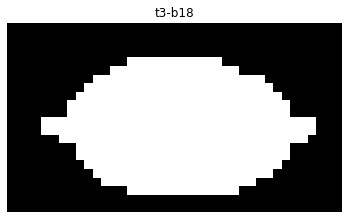

In [87]:
#  remove horizontal lines using normal morphology
all_notes=[]
counter =1
for j,trace in enumerate(bigger_trace_bounding_boxes):
    [Xmin, Xmax, Ymin, Ymax] = [x for x in trace]
    
    staff_no_lines = remove_horizontal_lines_old(original_image[Ymin:Ymax,Xmin:Xmax])
    
    
#     staff_of_bounding = binary_dilation(staff_no_lines, selem=rect(1,6))
    
    show_images([staff_no_lines],['hi'])
    temp = binary_dilation(staff_no_lines, selem=rect(division_height//2,division_height//2))
    show_images([temp], ['closed'])
    b_boxes = get_bounding_boxes(temp,(0,300))
    draw_bounding_boxes(staff_no_lines, b_boxes)
    
    staff2 = original_image[Ymin:Ymax,Xmin:Xmax]
    
    for i, box in enumerate(b_boxes):
        [Xmin, Xmax, Ymin, Ymax] = [x for x in box]
        # remove blank or noisy area that is less than a line of pixels
        if(np.sum([staff_no_lines[Ymin:Ymax,Xmin:Xmax]]) < division_height//2):
            continue
        char = staff_no_lines[Ymin:Ymax,Xmin:Xmax]
        char = binary_erosion(char, selem=rect(2,2))
        char = binary_dilation(char, selem=rect(2,2))
        show_images([char],[f't{j}-b{i}'])
#         skimage.io.imsave(f"no_line_test/t{j}-b{i}.jpg",staff_no_lines[Ymin:Ymax,Xmin:Xmax])
        counter+=1

In [12]:
skimage.io.imsave?

In [13]:
from skimage import data
from skimage.viewer import ImageViewer

image = original_image
viewer = ImageViewer(image)
viewer.show()

C:\Users\mohammed\anaconda3\lib\site-packages\skimage\viewer\utils\__init__.py:1: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  from .core import *


[]

-1

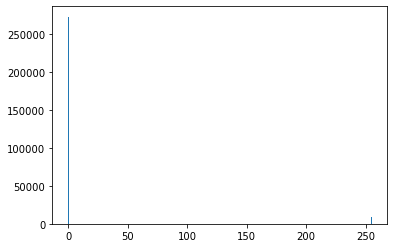

In [89]:
import cv2


image = cv2.imread('images/8th_Sheet1.jpeg')
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Remove horizontal
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25,1))
detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(image, [c], -1, (255,255,255), 2)

# Repair image
repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,6))
result = cv2.morphologyEx(255 - image, cv2.MORPH_CLOSE, repair_kernel, iterations=1)
result[result < 100] = 0
result[result >= 100] = 255
showHist(result)

cv2.imshow('thresh', thresh)
cv2.imshow('detected_lines', detected_lines)
cv2.imshow('image', image)
cv2.imshow('result', result)
cv2.waitKey()

In [15]:
m = [[0, 39, 10, 119], [18, 26, 17, 38], [814, 837, 20, 85], [409, 413, 32, 92], [721, 726, 32, 92], [1034, 1039, 32, 92], [59, 83, 33, 58], [118, 140, 36, 101], [188, 211, 36, 101], [258, 282, 36, 101], [431, 454, 36, 101], [501, 524, 36, 101], [571, 594, 36, 101], [744, 767, 36, 101], [66, 72, 42, 49], [954, 978, 48, 109], [877, 913, 53, 118], [5, 19, 54, 88], [59, 83, 65, 90], [17, 25, 70, 86], [28, 33, 71, 86], [66, 71, 75, 82], [1053, 1081, 85, 101], [577, 587, 87, 99], [1063, 1071, 87, 99], [265, 274, 88, 98]]
def x_min(shape):
    return shape[0]
m = sorted(m, key=x_min)
print(m)

[[0, 39, 10, 119], [5, 19, 54, 88], [17, 25, 70, 86], [18, 26, 17, 38], [28, 33, 71, 86], [59, 83, 33, 58], [59, 83, 65, 90], [66, 72, 42, 49], [66, 71, 75, 82], [118, 140, 36, 101], [188, 211, 36, 101], [258, 282, 36, 101], [265, 274, 88, 98], [409, 413, 32, 92], [431, 454, 36, 101], [501, 524, 36, 101], [571, 594, 36, 101], [577, 587, 87, 99], [721, 726, 32, 92], [744, 767, 36, 101], [814, 837, 20, 85], [877, 913, 53, 118], [954, 978, 48, 109], [1034, 1039, 32, 92], [1053, 1081, 85, 101], [1063, 1071, 87, 99]]
